### Model Training

We look at how the RNTN model is trained and some metrics such as cross entropy loss and accuracy change as the model is trained. The model is trained for a fixed number of epochs with an adaptive learning rate and early stop on decrease in cross-validation loss.

#### Training Parameters

##### Number of epochs

The number of epochs is determined empirically by observing when overfitting occurs or when the network stops learning. Overfitting is determined by when cross-validation loss increases even if training loss increases. 

For this network, the number of epochs was around 50 training passes over the dataset.

##### Batch Size

Batch size again was determined empirically to be between 20 and 30 training samples. Bigger training batches caused reduction in performance. The Adagrad optimizer runs after every batch to update weights using back propagation.

There is a smaller imbalance in training samples at root sentiment level, in comparison to the leaf level. A balanced batch of equal class distribution is generated using imblearn's balanced batch generator, which uses random undersampling by default.

##### Learning Rate

Learning Rate is again determined empirically. The loss function gives out NaN's for any values above 0.1 or 0.0001 training rates due to exploding and vanishing gradients respectively. 

![title](../docs/LR_Comp_Training.png)

Image credit: Andrew Ng's Coursera course on ML

![title](../docs/LR_Training.jpg)

Image Credit: cs231n

The initial learning rate is determined to be 0.01 and then it is adaptively changed based on following algorithm:
* If the cross-validation loss is less than itself from previous epoch, the learning rate is decreased
* If the cross-validation loss is less than threshold of 1% from previous epoch, the learning rate is increased.

For this network, learning rate of 0.01 gives the minimum amount of epochs needed for convergence.

#### Regularization

Regularization is needed for all model variables to prevent word embeddings and weights from increasing wildly. We use $L2$ loss which guarantees convergence to a unique stable solution, although it is not robust. The Regularization co-efficient is empirically determined to be 0.001, which is usually between 1% to 20% of the cross entropy loss.  

#### Fixing Class Imbalance

As we noticed in the earlier section, there is a huge imbalance at the leaves, with most of the words being marked neutral. To get around this oversampling was used for each tree to prevent the weights from learning only the majority class. 

We do not use undersampling at the tree level of processing as there is a huge information loss when the nodes are not used. The word vectors are already sparse and not using leaves does not train vocabulary enough. 

Oversampling leads to over-fitting, which manifests as negative words having more weights, or neural network having a more extreme view of both positives or negatives if leaf distribution proportion is used as weights.

A good balance is random oversampling of leaves instead of using weights. This leads to highest root sentiment accuracy seen so far, although the network mis-classifies extreme values as slightly extreme values.

Other methods such as Tomek-Link or SMOTE could give even better performance than just random oversampling, but they were not tried as these neighbour based methods require a well-defined metric to compare if the samples are near. Such a distance metric could be PARSEVAL metric for comparing parsed trees, but that adds significant complexity in model evaluation.

#### Loss Function

The loss function is chosen so as to maximize the probability of the sentiment label, which is the same as minimizing the KL Divergence of the labels. This minimal value is achieved using cross entropy loss over softmax distribution of the output of the neural network called logits in Tensorflow documentation. 

> Softmax Probabilities are computed as: $s(x) = \frac{e^{ax}}{\sum_{j} e^{ax}}$ where $j$ are the classes in the sentiment.

Another loss function tried was the max margin loss function, this function is computed as:
> Max Margin Loss $m(x) = max(0, 1 - s_{pos} + s_{neg})$ where,

$s_{pos}$ is the probability of the positive score.
$s_{neg}$ is the sum of probabilities of the negative scores, which are just randomly picked sentiment label.

The max-margin loss function is commonly used in SVM to maximize the distance between the training samples on the boundary of classification. In this case, the loss function did not give any better performance than the Cross-Entropy loss.

#### Tensorflow Graph

The generated tensorflow graph is shown below. It shows the sequence of computations from placeholders all the way to the final cross-entropy loss that is computed. 

The save part of the graph is used to save the model variables for non-tensorflow use. The two transpose functions represent the two main tensor products for the composition function. The loss node is represented by the softmax_cross_entropy_loss function. The following image was generated using Tensorboard.

![title](../docs/graph_RNTN_30_tanh_35_5_None_50_0.001_0.01.png)

#### Evaluation Metrics

The graphs below show how training/cross-validation loss was measured for various epochs.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
dt_cv_loss = pd.read_csv('../src/data/processed/run_RNTN_30_tanh_35_5_None_50_0.001_0.01_8544_training-tag-Logging_Variables_dev_epoch_loss.csv')
dt_train_loss = pd.read_csv('../src/data/processed/run_RNTN_30_tanh_35_5_None_50_0.001_0.01_8544_training-tag-Logging_Variables_train_epoch_loss.csv')
dt_cv_accuracy = pd.read_csv('../src/data/processed/run_RNTN_30_tanh_35_5_None_50_0.001_0.01_8544_training-tag-Logging_Variables_dev_epoch_accuracy.csv')
dt_train_accuracy = pd.read_csv('../src/data/processed/run_RNTN_30_tanh_35_5_None_50_0.001_0.01_8544_training-tag-Logging_Variables_train_epoch_accuracy.csv')

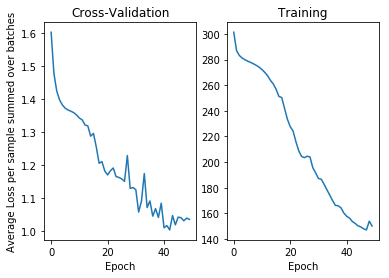

In [23]:
# Display Loss Graphs
plt.subplot(121)
plt.plot(dt_cv_loss[['Step']], dt_cv_loss[['Value']])
plt.title('Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss per sample summed over batches')
plt.subplot(122)
plt.plot(dt_train_loss[['Step']], dt_train_loss[['Value']])
plt.title('Training')
plt.xlabel('Epoch')
plt.show()

The spikes in the cross-validation loss graph correspond to the times when the learning rate was steadily decreased to find the local minimum.

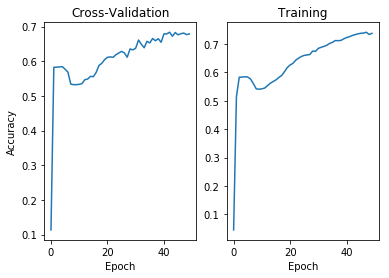

In [24]:
# Display Accuracy Graphs
plt.subplot(121)
plt.plot(dt_cv_accuracy[['Step']], dt_cv_accuracy[['Value']])
plt.title('Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(dt_train_accuracy[['Step']], dt_train_accuracy[['Value']])
plt.title('Training')
plt.xlabel('Epoch')
plt.show()

The accuracy steadily increases with each epoch until it plateaus at about 75% for training and 67% for cross-validation set. 